##  物体検出アルゴリズムのSSDでSimpthonsのキャラクラーを検出

In [1]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image as kimage
import matplotlib.pyplot as plt
import numpy as np
import pickle
from random import shuffle
from imageio import imread
# from scipy.misc import imread
from scipy.misc import imresize  #scipy v1.1.0 
from skimage.transform import resize
import tensorflow as tf
import ffmpeg #pip install --user ffmpeg-python
from ssd import SSD300
from ssd_training import MultiboxLoss
from ssd_utils import BBoxUtility


%matplotlib inline
plt.rcParams['figure.figsize'] =(8,8)
plt.rcParams['image.interpolation']='nearest'

np.set_printoptions(suppress=True)

Using TensorFlow backend.


アノテーションファイルを読み込む.

In [2]:
with open('./annotation.txt','r') as f:
    file = f.read()
    anno_list =file.split(',')
    name =[]
    #０行目が他と異なる文字列になるため除外、1行目から
    for i in range(1,len(anno_list)):
        #characterの名前をリストに格納
        if not anno_list[i].isdigit():
            name.append(anno_list[i].split('\n')[0])

In [3]:
# ユニークなキャラクター名の数をリストに格納
chr_name=[]
for i in name:
    if not i in chr_name:
        chr_name.append(i)

In [4]:
# SSDではどのクラスにも該当しないものを１クラスとして扱うのでクラス数に１を加える
NUM_CLASSES = len(chr_name)+1

In [5]:
NUM_CLASSES 

19

In [6]:
import collections
# キャラクラー名をkeyに、アノテーション数をvalueに辞書化
char_names=collections.Counter(name)
names_dict =dict(char_names)

In [7]:
names_dict 

{'abraham_grampa_simpson': 687,
 'apu_nahasapeemapetilon': 206,
 'bart_simpson': 650,
 'charles_montgomery_burns': 650,
 'chief_wiggum': 209,
 'comic_book_guy': 208,
 'edna_krabappel': 212,
 'homer_simpson': 718,
 'kent_brockman': 213,
 'krusty_the_clown': 429,
 'lisa_simpson': 756,
 'marge_simpson': 629,
 'milhouse_van_houten': 210,
 'moe_szyslak': 403,
 'ned_flanders': 675,
 'nelson_muntz': 219,
 'principal_skinner': 614,
 'sideshow_bob': 201}

In [8]:
# キャラクター名をラベル化
label_name={}
for i ,key in enumerate(names_dict) :
    label_name[key]=i
label_name

{'abraham_grampa_simpson': 0,
 'apu_nahasapeemapetilon': 1,
 'bart_simpson': 2,
 'charles_montgomery_burns': 3,
 'chief_wiggum': 4,
 'comic_book_guy': 5,
 'edna_krabappel': 6,
 'homer_simpson': 7,
 'kent_brockman': 8,
 'krusty_the_clown': 9,
 'lisa_simpson': 10,
 'marge_simpson': 11,
 'milhouse_van_houten': 12,
 'moe_szyslak': 13,
 'ned_flanders': 14,
 'nelson_muntz': 15,
 'principal_skinner': 16,
 'sideshow_bob': 17}

In [9]:
list(label_name.keys())[0]

'abraham_grampa_simpson'

In [10]:
anno_list = file.split(',')
gt = dict()
count=0

coordinate=[]
bounding_boxes=[]
one_hot_classes = []
for i in range(len(anno_list)):
    if anno_list[i].isdigit():
        coordinate.append(int(anno_list[i]))
        count +=1
    else:
        # リストの要素が文字列の場合、改行後の部分を記録
        if '\n' in anno_list[i]:
            key = anno_list[i].split('\n')[1][2:]
        else:
            key = anno_list[i][2:]
    if 4 <= count:
        key = key.split('/')[1] + '/' + key.split('/')[2]
        image = cv2.imread('./the-simpsons-characters-dataset/simpsons_dataset/' + key)
        h, w, _ = image.shape
        if (coordinate[0]<coordinate[2]) and (coordinate[1]<coordinate[3]):
            coordinate[0] /=w
            coordinate[1] /=h
            coordinate[2] /=w
            coordinate[3] /=h
            coordinate=coordinate
            
        one_hot_vector =(np.zeros(NUM_CLASSES-1))
        class_name = key.split('/')[0]
        one_hot_vector[label_name[class_name]]=1

        image_data = np.hstack((coordinate, one_hot_vector))[np.newaxis,:]
        gt[key] = image_data
        count =0
        coordinate = []

In [11]:
priors = pickle.load(open('prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)

### データセットを訓練用と検証用に分割

In [12]:
import random
val_ratio = 0.2
keys = sorted(gt.keys())
random.shuffle(keys)
num_train = int(round((1-val_ratio) * len(keys)))
train_keys = keys[:num_train]
val_keys = keys[num_train:]

In [13]:
class Generator(object):
    def __init__(self, gt, bbox_util,
                 batch_size, path_prefix,
                 train_keys, val_keys, image_size,
                 saturation_var=0.5,
                 brightness_var=0.5,
                 contrast_var=0.5,
                 lighting_std=0.5,
                 hflip_prob=0.5,
                 vflip_prob=0.5,
                 do_crop=True,
                 crop_area_range=[0.75, 1.0],
                 aspect_ratio_range=[3./4., 4./3.]):
        self.gt = gt
        self.bbox_util = bbox_util
        self.batch_size = batch_size
        self.path_prefix = path_prefix
        self.train_keys = train_keys
        self.val_keys = val_keys
        self.train_batches = len(train_keys)
        self.val_batches = len(val_keys)
        self.image_size = image_size
        self.color_jitter = []
        if saturation_var:
            self.saturation_var = saturation_var
            self.color_jitter.append(self.saturation)
        if brightness_var:
            self.brightness_var = brightness_var
            self.color_jitter.append(self.brightness)
        if contrast_var:
            self.contrast_var = contrast_var
            self.color_jitter.append(self.contrast)
        self.lighting_std = lighting_std
        self.hflip_prob = hflip_prob
        self.vflip_prob = vflip_prob
        self.do_crop = do_crop
        self.crop_area_range = crop_area_range
        self.aspect_ratio_range = aspect_ratio_range
        
    def grayscale(self, rgb):
        return rgb.dot([0.299, 0.587, 0.114])

    def saturation(self, rgb):
        gs = self.grayscale(rgb)
        alpha = 2 * np.random.random() * self.saturation_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha + (1 - alpha) * gs[:, :, None]
        return np.clip(rgb, 0, 255)

    def brightness(self, rgb):
        alpha = 2 * np.random.random() * self.brightness_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha
        return np.clip(rgb, 0, 255)

    def contrast(self, rgb):
        gs = self.grayscale(rgb).mean() * np.ones_like(rgb)
        alpha = 2 * np.random.random() * self.contrast_var 
        alpha += 1 - self.contrast_var
        rgb = rgb * alpha + (1 - alpha) * gs
        return np.clip(rgb, 0, 255)

    def lighting(self, img):
        cov = np.cov(img.reshape(-1, 3) / 255.0, rowvar=False)
        eigval, eigvec = np.linalg.eigh(cov)
        noise = np.random.randn(3) * self.lighting_std
        noise = eigvec.dot(eigval * noise) * 255
        img += noise
        return np.clip(img, 0, 255)
    
    def horizontal_flip(self, img, y):
        if np.random.random() < self.hflip_prob:
            img = img[:, ::-1]
            y[:, [0, 2]] = 1 - y[:, [2, 0]]
        return img, y
    
    def vertical_flip(self, img, y):
        if np.random.random() < self.vflip_prob:
            img = img[::-1]
            y[:, [1, 3]] = 1 - y[:, [3, 1]]
        return img, y
    
    def random_sized_crop(self, img, targets):
        img_w = img.shape[1]
        img_h = img.shape[0]
        img_area = img_w * img_h
        random_scale = np.random.random()
        random_scale *= (self.crop_area_range[1] -
                         self.crop_area_range[0])
        random_scale += self.crop_area_range[0]
        target_area = random_scale * img_area
        random_ratio = np.random.random()
        random_ratio *= (self.aspect_ratio_range[1] -
                         self.aspect_ratio_range[0])
        random_ratio += self.aspect_ratio_range[0]
        w = np.round(np.sqrt(target_area * random_ratio))     
        h = np.round(np.sqrt(target_area / random_ratio))
        if np.random.random() < 0.5:
            w, h = h, w
        w = min(w, img_w)
        w_rel = w / img_w
        w = int(w)
        h = min(h, img_h)
        h_rel = h / img_h
        h = int(h)
        x = np.random.random() * (img_w - w)
        x_rel = x / img_w
        x = int(x)
        y = np.random.random() * (img_h - h)
        y_rel = y / img_h
        y = int(y)
        img = img[y:y+h, x:x+w]
        new_targets = []
        for box in targets:
            cx = 0.5 * (box[0] + box[2])
            cy = 0.5 * (box[1] + box[3])
            if (x_rel < cx < x_rel + w_rel and
                y_rel < cy < y_rel + h_rel):
                xmin = (box[0] - x_rel) / w_rel
                ymin = (box[1] - y_rel) / h_rel
                xmax = (box[2] - x_rel) / w_rel
                ymax = (box[3] - y_rel) / h_rel
                xmin = max(0, xmin)
                ymin = max(0, ymin)
                xmax = min(1, xmax)
                ymax = min(1, ymax)
                box[:4] = [xmin, ymin, xmax, ymax]
                new_targets.append(box)
        new_targets = np.asarray(new_targets).reshape(-1, targets.shape[1])
        return img, new_targets
    
    def generate(self, train=True):
        while True:
            if train:
                shuffle(self.train_keys)
                keys = self.train_keys
            else:
                shuffle(self.val_keys)
                keys = self.val_keys
            inputs = []
            targets = []
            for key in keys:            
                img_path = self.path_prefix + key
                img = imread(img_path).astype('float32')
                y = self.gt[key].copy()
                if train and self.do_crop:
                    img, y = self.random_sized_crop(img, y)
                img = imresize(img, self.image_size).astype('float32')
                if train:
                    shuffle(self.color_jitter)
                    for jitter in self.color_jitter:
                        img = jitter(img)
                    if self.lighting_std:
                        img = self.lighting(img)
                    if self.hflip_prob > 0:
                        img, y = self.horizontal_flip(img, y)
                    if self.vflip_prob > 0:
                        img, y = self.vertical_flip(img, y)
                y = self.bbox_util.assign_boxes(y)
                inputs.append(img)                
                targets.append(y)
                if len(targets) == self.batch_size:
                    tmp_inp = np.array(inputs)
                    tmp_targets = np.array(targets)
                    inputs = []
                    targets = []
                    yield preprocess_input(tmp_inp), tmp_targets

In [14]:
input_shape = (300, 300, 3)

In [15]:
path_prefix = './the-simpsons-characters-dataset/simpsons_dataset/'
gen = Generator(gt, bbox_util, 16, path_prefix,
                train_keys, val_keys,
                (input_shape[0], input_shape[1]), do_crop=False)

In [16]:
# 学習モデルを生成 
model = SSD300(input_shape, num_classes=NUM_CLASSES)


In [109]:
# finetuning時に使用

# freeze = ['input_1', 'conv1_1', 'conv1_2', 'pool1',
#           'conv2_1', 'conv2_2', 'pool2',
#           'conv3_1', 'conv3_2', 'conv3_3', 'pool3']

# for L in model.layers:
#     if L.name in freeze:
#         L.trainable = False

In [110]:
def schedule(epoch, decay=0.9):
    return base_lr * decay**(epoch)

callbacks = [keras.callbacks.ModelCheckpoint('./checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                                             verbose=1,
                                             save_weights_only=True),
             keras.callbacks.LearningRateScheduler(schedule)]


In [111]:
base_lr = 3e-4
optim = keras.optimizers.Adam(lr=base_lr)
# optim = keras.optimizers.RMSprop(lr=base_lr)
# optim = keras.optimizers.SGD(lr=base_lr, momentum=0.9, decay=decay, nesterov=True)
model.compile(optimizer=optim,
              loss=MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss)

In [ ]:
epochs  = 30
history = model.fit_generator(gen.generate(True), steps_per_epoch=gen.train_batches//16,
                              epochs=epochs, verbose=1,
                              callbacks=callbacks,
                              validation_data=gen.generate(False),
                              validation_steps=gen.val_batches
                                       )

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:148: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/ubuntu/ssd_utils.py:114: RuntimeWarning: invalid value encountered in log
  assigned_priors_wh)


109/337 [========>.....................] - ETA: 6:06 - loss: 4.7058

/home/ubuntu/ssd_utils.py:114: RuntimeWarning: divide by zero encountered in log
  assigned_priors_wh)


337/337 [==============================] - 905s 3s/step - loss: 4.3683 - val_loss: 3.9213

Epoch 00001: saving model to ./checkpoints/weights.01-3.92.hdf5
Epoch 2/30
337/337 [==============================] - 845s 3s/step - loss: 3.9199 - val_loss: 3.7215

Epoch 00002: saving model to ./checkpoints/weights.02-3.72.hdf5
Epoch 3/30
337/337 [==============================] - 840s 2s/step - loss: 3.7196 - val_loss: 3.6385

Epoch 00003: saving model to ./checkpoints/weights.03-3.64.hdf5
Epoch 4/30
337/337 [==============================] - 834s 2s/step - loss: 3.5437 - val_loss: 3.4535

Epoch 00004: saving model to ./checkpoints/weights.04-3.45.hdf5
Epoch 5/30
337/337 [==============================] - 834s 2s/step - loss: 3.4006 - val_loss: 3.3239

Epoch 00005: saving model to ./checkpoints/weights.05-3.32.hdf5
Epoch 6/30
337/337 [==============================] - 834s 2s/step - loss: 3.2881 - val_loss: 3.2039

Epoch 00006: saving model to ./checkpoints/weights.06-3.20.hdf5
Epoch 7/30
337/

In [25]:
inputs = []
images = []
for i in range(0,760,15):
    img_path = path_prefix + sorted(val_keys)[i]
    img = kimage.load_img(img_path, target_size=(300, 300))
    img = kimage.img_to_array(img)
    images.append(imread(img_path))
    inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

In [26]:
model.load_weights('./checkpoints/weights.25-2.31.hdf5')

In [28]:
preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

51/51 [==============================] - 48s 950ms/step


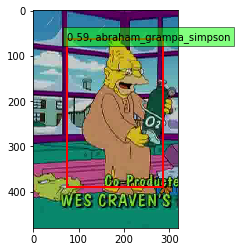

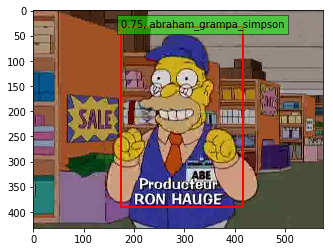

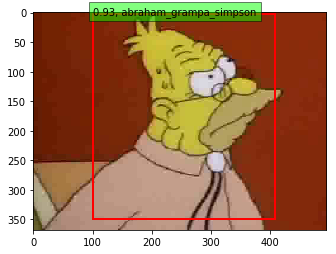

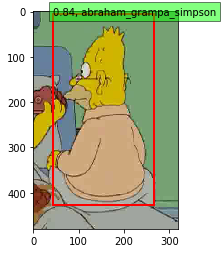

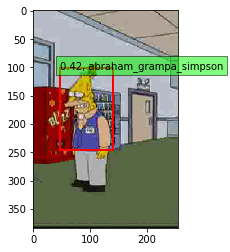

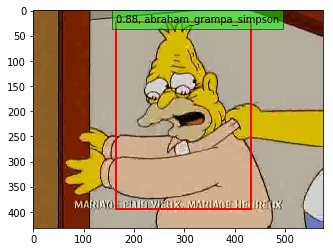

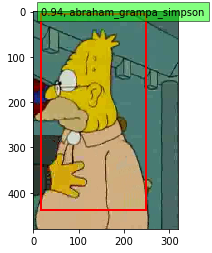

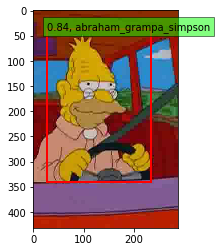

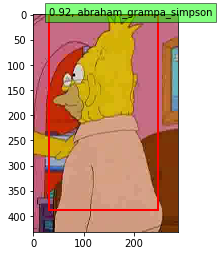

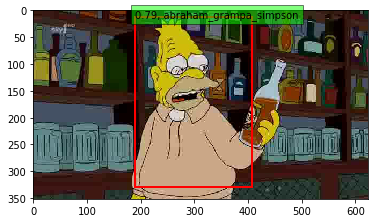

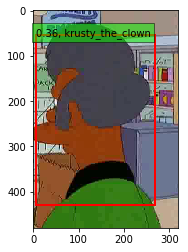

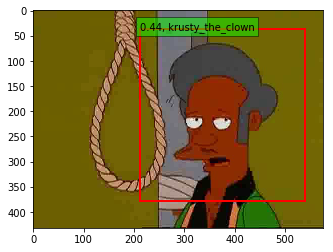

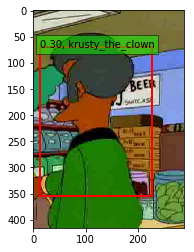

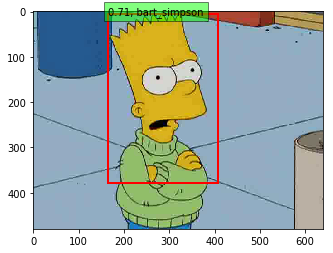

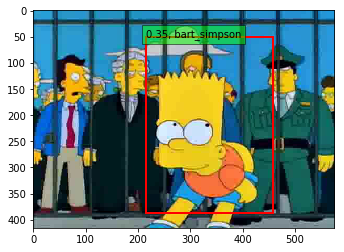

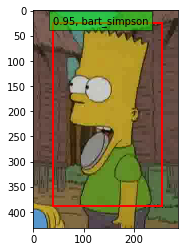

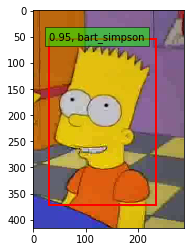

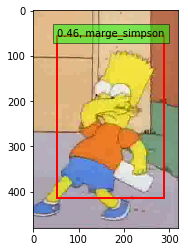

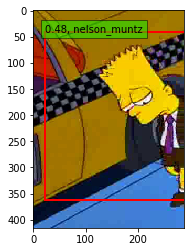

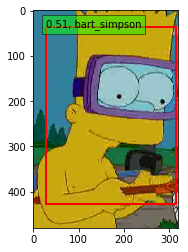

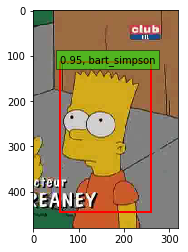

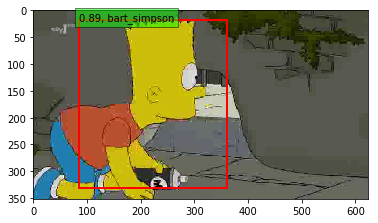

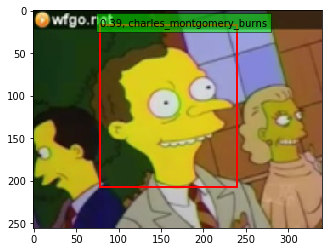

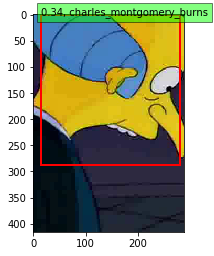

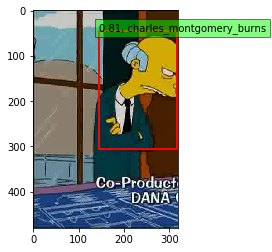

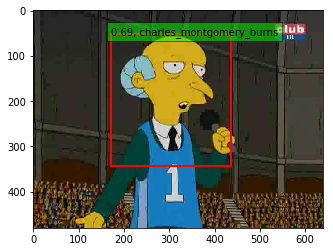

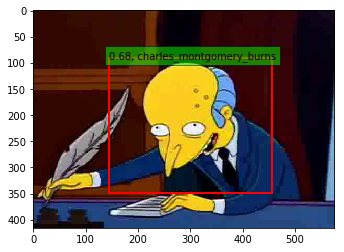

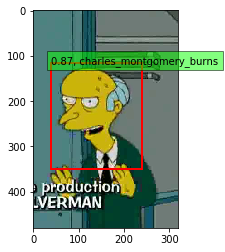

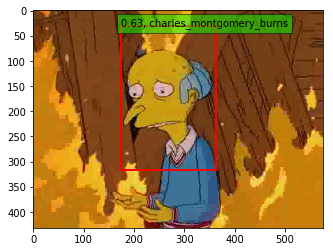

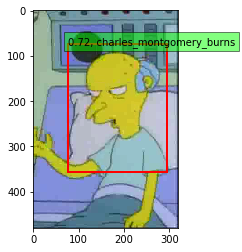

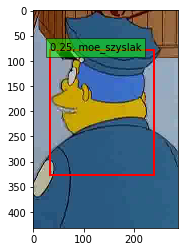

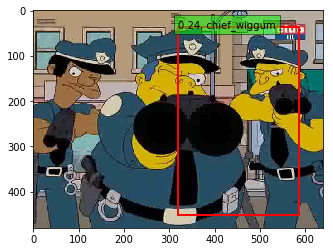

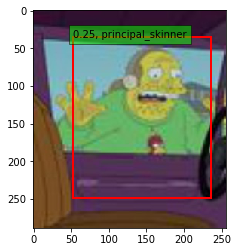

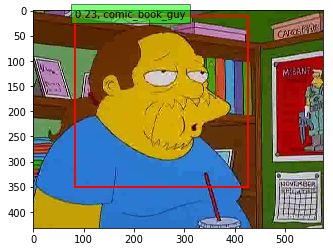

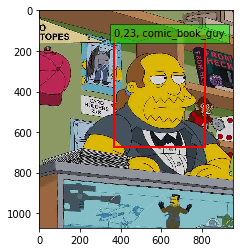

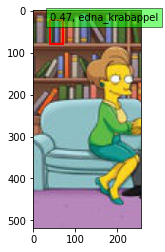

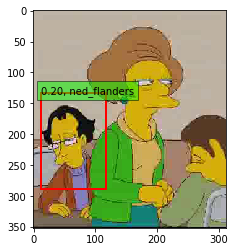

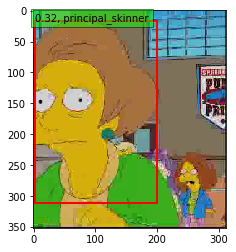

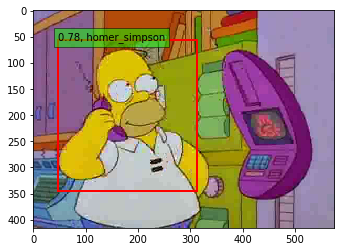

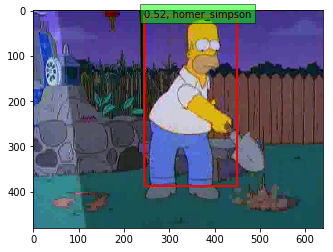

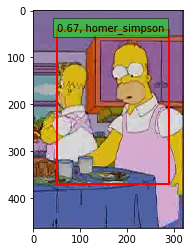

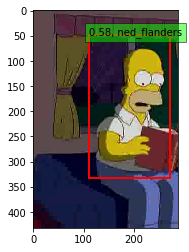

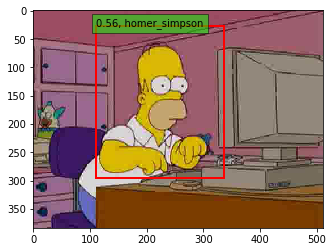

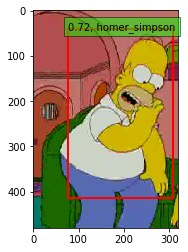

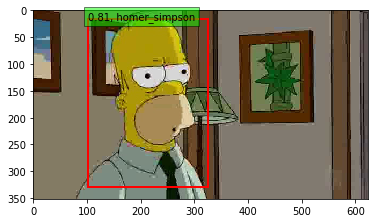

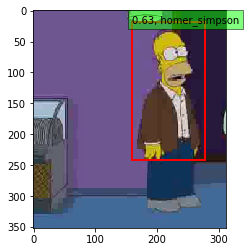

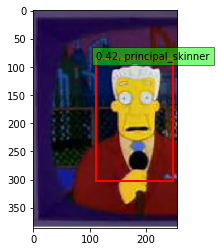

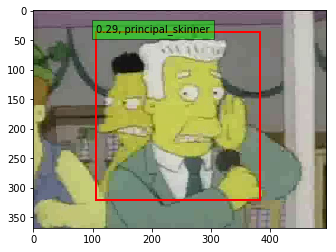

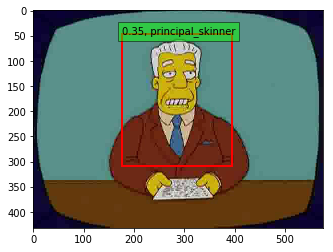

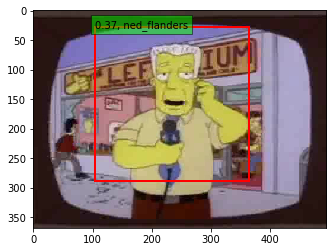

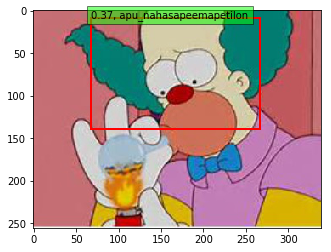

In [32]:
for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    #インデックスを返す
    top_indices = [np.where(det_conf==np.max(det_conf))[0][0]] 
    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        name = [name for name, value in label_name.items() if value == label-1][0]
        display_txt = '{:0.2f}, {}'.format(score, name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
#         color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor='red', linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()

In [20]:
import keras
import pickle
from videotest import VideoTest

import sys
sys.path.append("..")
from ssd import SSD300 as SSD

input_shape = (300,300,3)

class_names = ['abraham_grampa_simpson', 'apu_nahasapeemapetilon',
                        'bart_simpson','charles_montgomery_burns', 'chief_wiggum',
                        'comic_book_guy','edna_krabappel','homer_simpson',
                        'kent_brockman', 'krusty_the_clown', 'lisa_simpson',
                        'marge_simpson', 'milhouse_van_houten','moe_szyslak',
                        'ned_flanders', 'nelson_muntz', 'principal_skinner', 'sideshow_bob']

NUM_CLASSES = len(class_names)+1

model = SSD(input_shape, num_classes=NUM_CLASSES)

# 学習した重みを使用
model.load_weights('./weights.04-2.26.hdf5') 
        
vid_test = VideoTest(class_names, model, input_shape)

# To test on webcam 0, remove the parameter (or change it to another number
# to test on that webcam)
# vid_test.run(0)
vid_test.run('./Simpsons Intro HD.mp4')

AttributeError: module 'cv2' has no attribute 'cv'